# Progetto ML Traccia A1: MedMNIST-Pneumonia - Filippo Muscherà (0338276)

## Goal

Lo scopo di questo progetto è quello di andare a modellare e addestrare alcuni modelli di ML, e compararli nel task di classificazione binaria del dataset MedMNIST-Pneumonia.
<br>
L'idea è quella di addestrare vari modelli, cercare di migliorarli e, infine, confrontarli per scegliere il migliore.

## Import e Utility Functions

Si raccolgono in questa cella tutti gli import necessari per il notebook.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal
from tensorflow.keras.utils import plot_model
import pydot
from keras.preprocessing.image import ImageDataGenerator
import warnings
import seaborn as sns
from matplotlib.colors import Normalize
warnings.filterwarnings("ignore") # ignora un FutureWarning di Pandas
tf.random.set_seed(42)

Queste funzioni hanno lo scopo di leggere e scrivere da/su un file .csv, utilizzato per salvare gli accuracy score e gli F1 score dei vari modelli. 

In [2]:
def add_result_to_csv(model_name, accuracy, file_name='results.csv'):
    # Check if the file exists
    file_exists = os.path.isfile(file_name)
    
    # If the file exists, read it into a DataFrame
    if file_exists:
        df = pd.read_csv(file_name)
    else:
        # If the file does not exist, create an empty DataFrame
        df = pd.DataFrame(columns=['Model', 'Value'])
    
    # Create a new DataFrame with the new result
    new_data = pd.DataFrame([[model_name, accuracy]], columns=['Model', 'Value'])
    
    # Concatenate the existing DataFrame with the new data
    df = pd.concat([df, new_data], ignore_index=True)
    
    # Save the updated DataFrame to the CSV file
    df.to_csv(file_name, index=False)

In [3]:
def read_value_from_csv(model_name, csv_file_name='results.csv'):
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file_name)

        # Find the accuracy corresponding to the model name
        accuracy = df.loc[df['Model'] == model_name, 'Value'].values[0]

        return accuracy
    
    except FileNotFoundError:
        print(f"File '{csv_file_name}' not found.")
        return None
    except IndexError:
        print(f"Model '{model_name}' not found in file '{csv_file_name}'.")
        return None

In [4]:
# Controlla le GPU disponibili, verrà utilizzata per l'addestramento delle CNN. 
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Numero di GPU disponibili: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome GPU: {gpu.name}")
else:
    print("Nessuna GPU disponibile")

Numero di GPU disponibili: 1
Nome GPU: /physical_device:GPU:0


## Import e Pre-processamento Dataset

Si procede al caricamento del dataset. Il dataset viene poi inizialmente suddiviso in train e test set. Per questa suddivisione su utilizza un seed in modo che l'operazione sia ripetibile per run diverese del notebook.
<br>
Il dataset contiene 5232 esempi. Si sceglie di avere un testing set con una size pari al 10% della size totale del dataset.
<br>
Si vanno ad eseguire anche dei semplici controlli di consistenza sulle label del dataset.

In [5]:
x = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_images.npy")
y = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_labels.npy")

#creazione dei vari dataset
seed = 1999
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

print("Numero di immagini totale = ", len(x))
print("Numero di immagini nel testing set = ", len(test_images))

# Check di consistenza sul dataset
assert np.all((train_labels == 0) | (train_labels == 1)) # check: tutte le label del training set siano 0/1 (niente valori NULL per es.)
assert np.all((test_labels == 0) | (test_labels == 1)) # stesso check per il testing set
assert len(x) == len(y) # assert su numero esempi e numero label

Numero di immagini totale =  5232
Numero di immagini nel testing set =  524


Le "train_images" vengono suddivise ulteriormente in training set e validation set. Questo viene fatto allo scopo di utilizzare il validation set per il tuining degli iper-parametri, in modo da utilizzare il testing set solo alla fine, per valutare le prestazioni del modello ottenuto su dati che non ha mai visto in precedenza.
<br>
Il training set viene realizzato in modo da comprendere l'80% degli esempi del dataset a cui era stato già rimosso il testing set. Il rimanente verrà utilizzato come valdiation set.
<br>
Le immagini, come da best-practice, vengono anche normalizzate. 

In [6]:
# creazione validation set e train set con split 80/20 a favore del training set
x_valid_images = train_images[3765:]/255. # normalizzazione
x_valid_labels = train_labels[3765:]
x_train_images = train_images[:3765]/255. # normalizzazione
x_train_labels = train_labels[:3765]

#normalizzazione test set
test_images = test_images/255.

print("Suddivisione finale training, validation e test set:")
print("Numero di immagini nel training set = ", len(x_train_images))
print("Numero di immagini nel validation set = ", len(x_valid_images))
print("Numero di immagini nel testing set = ", len(test_images))


Suddivisione finale training, validation e test set:
Numero di immagini nel training set =  3765
Numero di immagini nel validation set =  943
Numero di immagini nel testing set =  524


Si va ora ad osservare alcune immagini del dataset con le relative etichette.

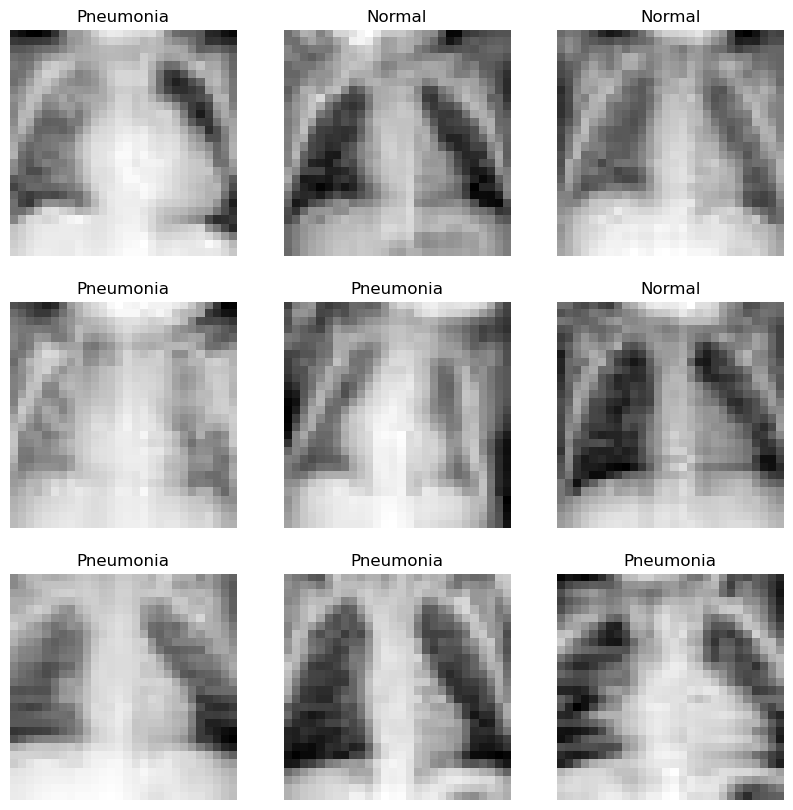

In [7]:
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_images[i], cmap='gray')
    label = 'Normal' if  x_train_labels[i] == 0 else 'Pneumonia'
    plt.title(label)
    plt.axis("off")

Prima di passare ai modelli, si decide anche di osservare la distribuzione delle due classi nel dataset.

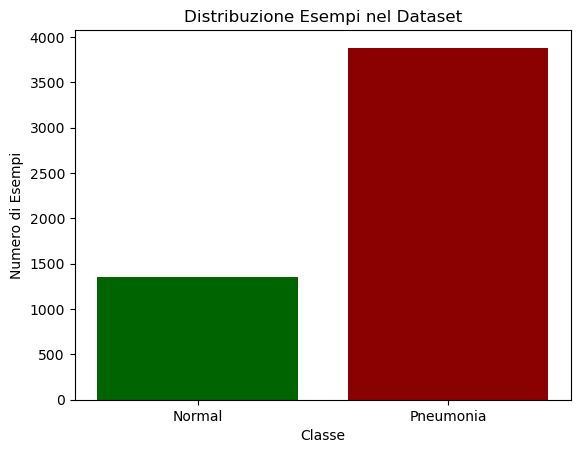

In [8]:
# Conta occorrenze
unique, counts = np.unique(y, return_counts=True)
labels_counts = dict(zip(unique, counts))

# Creazione grafico
fig, ax = plt.subplots()
ax.bar(labels_counts.keys(), labels_counts.values(), color=['darkgreen', 'darkred'])
ax.set_xlabel('Classe')
ax.set_ylabel('Numero di Esempi')
ax.set_title('Distribuzione Esempi nel Dataset')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Normal', 'Pneumonia'])

plt.show()


Si può notare come il dataset non sia bilanciato: le immagini della classe "Pneumonia" (label = 1) sono quasi il triplo rispetto a quelle dell'altra classe. 

## Random Forest

Il primo modello che si va a definire è quello di Random Forest. Questo modello spesso viene utilizzato, con buoni risultati, per i task di classificazione. Si sceglie perrtanto di partire con questo modello anche per fornire una baseline a tutti i successivi modelli. Difficilmente questo potrà essere il miglior modello, ma lo si userà come metro di paragone. 
<br>
Si utilizza una grid search per cercare di ottenere il miglior modello tra tutti quelli considerati. 

In [9]:
# reshape delle immagini dato che RF non può lavorare con dati di input che possiedono una rappresentazione a griglia/tensore
x_train_flat = x_train_images.reshape(x_train_images.shape[0], -1)
x_valid_flat = x_valid_images.reshape(x_valid_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# Creazione del modello di Random Forest
rf = RandomForestClassifier(random_state=42) # seed per rendere l'esecuzione ripetibile

# Definizione della griglia degli iperparametri
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Creazione della grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Addestramento della grid search
grid_search.fit(x_train_flat, x_train_labels.ravel()) # circa 12 minuti per la grid search

# Migliori iperparametri trovati
print("Best parameters found: ", grid_search.best_params_)

# Valutazione del modello sul validation set
best_rf = grid_search.best_estimator_
valid_predictions = best_rf.predict(x_valid_flat)
accuracy = accuracy_score(x_valid_labels.ravel(), valid_predictions)
print("Validation set accuracy: ", accuracy)

# Valutazione finale sul test set
test_predictions = best_rf.predict(test_flat)
test_accuracy_random_forest = accuracy_score(test_labels.ravel(), test_predictions)
print("Test set accuracy: ", test_accuracy_random_forest)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Validation set accuracy:  0.95864262990456
Test set accuracy:  0.9599236641221374


Il miglior modello trovato tramite la grid search utilizza 200 alberi, e ha come criterio per la scelta del miglior split 'Entropy', che corrisponde quindi all'Information Gain. Da notare anche come questo modello non utilizzi il bootstrapping, e quindi gli alberi del Random Forest sono costruiti tutti a partire dallo stesso identico dataset. 
<br>
Il modello migliore ha una accuracy sul testing set che sfiora il 96%. Anche sul validation set il risultato è simile.
<br>
In questo caso il validation set non viene utilizzato durante il training perché viene utilizzata la cross-validation. Si sarebbe anche potuto scegliere quindi di unire training set e validation set in questo caso, visto l'utilizzo della cross validation. Tuttavia si è scelto di non farlo per poter confrotare i vari modelli in maniera più 'fair' possibile, utilizzando lo stesso training set per tutti. 

In [49]:
# Calcolo della confusion matrix sul test set
cm_rf = confusion_matrix(test_labels.ravel(), test_predictions)

# Calcolo dell'F1 score sul test set
f1_rf = f1_score(test_labels.ravel(), test_predictions)

In [48]:
add_result_to_csv('Random Forest', test_accuracy_random_forest) # aggiunta entry per RF nel .csv
add_result_to_csv('Random Forest', f1_rf, 'f1.csv') # aggiunta entry per l'F1 score

In [12]:
report_test = classification_report(test_labels.ravel(), best_rf.predict(test_flat))
print(report_test)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       132
           1       0.97      0.97      0.97       392

    accuracy                           0.96       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.96      0.96      0.96       524



## Regressione Logistica

Il secondo modello considerato per la classificazione binaria è quello della regressione logistica. Anche in questo caso si è utilizzata una grid search. In particolare, in questo caso, è stata realizzata per provare tutti i solver con tutte le possibili tecniche di penalty per la regolarizzazione. 

In [13]:
lr = LogisticRegression(random_state=42, max_iter=100)

# Definizione della griglia degli iperparametri per la regressione logistica
param_grid_logreg = [
    {'C': [0.01, 0.1, 1, 10, 100], # termine per la regolarizzazione. Più è piccolo più è forte 
     'solver': ['liblinear'],
     'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'],
     'penalty': ['l1', 'l2', 'elasticnet'],
     'l1_ratio': [0.5]},  # l1_ratio è richiesto per elasticnet
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
     'penalty': ['l2']}
]
# Creazione della grid search
grid_search_logreg = GridSearchCV(estimator=lr, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=3)

In [14]:
# Addestramento della grid search
grid_search_logreg.fit(x_train_flat, x_train_labels.ravel())

# Migliori iperparametri trovati
print("Best parameters found for Logistic Regression: ", grid_search_logreg.best_params_)

# Valutazione del modello sul validation set
best_logreg = grid_search_logreg.best_estimator_
valid_predictions_logreg = best_logreg.predict(x_valid_flat)
accuracy_logreg = accuracy_score(x_valid_labels.ravel(), valid_predictions_logreg)
print("Validation set accuracy for Logistic Regression: ", accuracy_logreg)

# Valutazione finale sul test set
test_predictions_logreg = best_logreg.predict(test_flat)
test_accuracy_logreg = accuracy_score(test_labels.ravel(), test_predictions_logreg)
print("Test set accuracy for Logistic Regression: ", test_accuracy_logreg)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found for Logistic Regression:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation set accuracy for Logistic Regression:  0.9565217391304348
Test set accuracy for Logistic Regression:  0.9713740458015268


La grid search ci restituisce il miglior modello tra quelli testati. Questo modello si dimostra già migliore del Random Forest per quanto riguarda l'accuracy, che raggiunge il 97.1% sul test set. 

In [50]:
# Calcolo della confusion matrix sul test set
cm_logreg = confusion_matrix(test_labels.ravel(), test_predictions_logreg)

# Calcolo dell'F1 score sul test set
f1_logreg = f1_score(test_labels.ravel(), test_predictions_logreg)

In [51]:
add_result_to_csv('Logistic Regression', test_accuracy_logreg)
add_result_to_csv('Logistic Regression', f1_logreg, 'f1.csv')


In [52]:
report_test_logreg = classification_report(test_labels.ravel(), test_predictions_logreg)
print(report_test_logreg)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       132
           1       0.99      0.97      0.98       392

    accuracy                           0.97       524
   macro avg       0.96      0.97      0.96       524
weighted avg       0.97      0.97      0.97       524



Anche l'F1 score della Regressione logistica è migliore di quello di Random Forest, sia nella macro avg (non pesata sulla classi) che nella weighted avg, dove invece viene pesata sulla distribuzione degli esempi.  

## CNN

Il prossimo modello che si va a realizzare è una rete neurale. In particolare, dato che il dataset è composto da immagini, si decide di utilizzare direttamente una **CNN**.
<br>
Sarebbe infatti possibile anche utilizzare una DNN, ma si avrebbero due svantaggi. Non si potrebbero sfruttare le informazioni che potenzialmente possono fornire pixel che si trovano adiacenti, perché le immagini andrebbero vettorizzate e si perderebbe la loro rappresentazione come matrice/griglia. Inoltre, avendo solamente livelli completamente connessi, si andrebbe ad avere un numero di parametri ben più alto a parità di livelli. Risulterebbe quindi anche più lungo il processo di addestramento della rete.
<br>
<br>
Questa CNN è stata realizzata ispirandosi a *LeNet*, alternando dunque livelli di convoluzione e livelli di pooling. Si sono poi aggiunti in coda dei livelli densi per la classificazione delle immagini, effettuata utilizzando le feature estratte dai filtri dei livelli convoluzionali. 
<br>
Per evitare di rendere il notebook eccessivamente lungo si è riportata direttamente la versione che ha mostrato le migliori performance. In particolare, si sono provati diversi valori per il numero di filtri e la loro dimensione. Inoltre si è visto che, per questa rete, l'utilizzo dell'average pooling produce risultati migliori rispetto al max pooling. 
Anche l'utilizzo di funzioni per la norm penalties (L1, L2) non ha migliorato il modello, producendo underfitting.
<br>
Essendo questa la prima CNN realizzata, si è scelto di realizzare un modello relativamente semplice per osservarne le prestazioni. Si è inoltre visto che l'aggiunta di ulteriori hidden units non portava a miglioramenti sensibili sull'accuracy, ma solo a tempi di addestramento più lunghi. 
<br>
<br>
Per l'addestramento l'optimizer migliore si è dimostrato essere ADAM. Si è utilizzato un numero di epoche relativamente alto (300), con la consapevolezza che si è definita anche una callback per l'early stopping. In questo modo, anche se il numero di epoche dovesse essere eccessivo e potrebbe portare il modello in overfitting, si avrà l'early stopping a fermare l'addestramento e ripristinare i parametri dell'epoca migliore.

In [18]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42) # best for ReLu
con_init = keras.initializers.GlorotUniform(seed=42) # default ma con seed fissato per ripetibilità 

CNN_lenet = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1), kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Conv2D(20, kernel_size=(5, 5), activation='relu', kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dense(128, activation='relu', kernel_initializer=init),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 9s 17ms/step - loss: 0.3158 - accuracy: 0.8592 - val_loss: 0.2000 - val_accuracy: 0.9152
Epoch 2/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1919 - accuracy: 0.9216 - val_loss: 0.1707 - val_accuracy: 0.9300
Epoch 3/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9355 - val_loss: 0.1314 - val_accuracy: 0.9512
Epoch 4/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1541 - accuracy: 0.9378 - val_loss: 0.1251 - val_accuracy: 0.9502
Epoch 5/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1480 - accuracy: 0.9429 - val_loss: 0.1411 - val_accuracy: 0.9449
Epoch 6/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9458 - val_loss: 0.1756 - val_accuracy: 0.9279
Epoch 7/300
118/118 [==============================] - 0s 3ms/step - loss: 0.1225 - accuracy: 0.9541 - val_loss: 0.1033 - val_accuracy: 0.958

In [53]:
#test set
_ , cnn_lenet_accuracy = CNN_lenet.evaluate(test_reshaped, test_labels)
print('CNN_lenet_accuracy over test set = ', cnn_lenet_accuracy)

y_pred_probs = CNN_lenet.predict(test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet = f1_score(y_true, y_pred)
print(f'F1 Score: {f1_cnn_lenet}')

# Calcolare la Confusion Matrix
cm_cnn_lenet = confusion_matrix(y_true, y_pred)

17/17 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9733
CNN_lenet_accuracy over test set =  0.9732824563980103
F1 Score: 0.9819587628865979


L'early stopping ferma l'aggiornamento dopo 29 eopche. Essendo questa una CNN abbastanza semplice era prevedibile che l'addestramento avrebbe richiesto un numero di epoche abbastanza ridotto.
<br>
L'accuracy di questo modello sul testing set è di 97.33%, andando già a migliorare leggermente i risultati ottenuti con la Logistic Regression. 

In [54]:
add_result_to_csv('CNN LeNet', cnn_lenet_accuracy)
add_result_to_csv('CNN LeNet', f1_cnn_lenet, 'f1.csv')
CNN_lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               128256    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

Infine andiamo ad osservare la struttura di questa CNN. Qui si nota come il numero di parametri relativi ai due livelli densi vada a costituire quasi il 97% dei parametri totali.

### CNN + Dropout

Con l'obiettivo di avere un modello che generalizzi meglio su dati che non ha mai visto in precedenza si sceglie di inserire nella CNN appena definita dei livelli di Dropout. 
<br>
La rete precedente, infatti, sembrava ottenere spesso risultati migliori sul training set rispetto al validation set. Questo potrebbe voler dire che quella rete stava imparando (almeno in parte) pattern specifici del training set, andando leggermente in overfitting. Questo ha contribuito a determinare la scelta dell'impiego del Dropout. 
Il dropout è stato inserito sia per i livelli densi, sia dopo i livelli di pooling. I valori migliori si sono rivelati 0.35 per i livelli di Pooling e 0.7 per quelli Dense.

In [44]:
x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42)

CNN_lenet_opt = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1)),
    AveragePooling2D(pool_size=(2, 2),strides=2),        
    Dropout(0.35),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.35),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet_opt = CNN_lenet_opt.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])

Epoch 1/300
118/118 [==============================] - 2s 8ms/step - loss: 0.5732 - accuracy: 0.7339 - val_loss: 0.5467 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 1s 5ms/step - loss: 0.4111 - accuracy: 0.7795 - val_loss: 0.2554 - val_accuracy: 0.8950
Epoch 3/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2907 - accuracy: 0.8839 - val_loss: 0.1822 - val_accuracy: 0.9236
Epoch 4/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2678 - accuracy: 0.8903 - val_loss: 0.1830 - val_accuracy: 0.9268
Epoch 5/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2302 - accuracy: 0.9092 - val_loss: 0.1595 - val_accuracy: 0.9406
Epoch 6/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9150 - val_loss: 0.2869 - val_accuracy: 0.8653
Epoch 7/300
118/118 [==============================] - 1s 4ms/step - loss: 0.1983 - accuracy: 0.9216 - val_loss: 0.1343 - val_accuracy: 0.9480

In [45]:
#test set
_ , CNN_lenet_opt_accuracy = CNN_lenet_opt.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_accuracy over test set = ', CNN_lenet_opt_accuracy)

y_pred_probs2 = CNN_lenet_opt.predict(test_reshaped)
y_pred2 = (y_pred_probs2 > 0.5).astype(int).flatten()
y_true2 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet_opt = f1_score(y_true2, y_pred2)
print(f'F1 Score: {f1_cnn_lenet_opt}')

# Calcolare la Confusion Matrix
cm_cnn_lenet_opt = confusion_matrix(y_true2, y_pred2)

17/17 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9752
CNN_lenet_opt_accuracy over test set =  0.9751908183097839
F1 Score: 0.9833971902937421


Dopo aver eseguito il training della rete neurale, si analizzano i risultati ottenuti sul testing set. 
<br>
Si nota subito un ulteriore miglioramento dell'accuracy: la CNN con il Dropout riesce a generalizzare meglio le relazioni sui dati, e ottiene un'accuracy del 97.52% sui dati del testing set. 

In [55]:
add_result_to_csv('CNN LeNet Dropout', CNN_lenet_opt_accuracy)
add_result_to_csv('CNN LeNet Dropout', f1_cnn_lenet_opt, 'f1.csv')
CNN_lenet_opt.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_12 (Averag (None, 5, 5, 20)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 500)              

La struttura del modello è quindi rimasta invariata, ma riesce a generalizzare meglio grazie all'utilizzo del Dropout.

### CNN + Dropout + Batch Normalization

Come ulteriore possibile miglioramento per questo modello si è andati ad utilizzare la Batch Normalization.

In [24]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Costruzione della rete con batch normalization
CNN_lenet_opt_bn = Sequential([
    Conv2D(10, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.35),

    Conv2D(20, kernel_size=(5, 5)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.35),

    Flatten(),

    Dense(256, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(128, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(1, activation='sigmoid')
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilazione del modello
CNN_lenet_opt_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history_cnn_lenet_bn = CNN_lenet_opt_bn.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 2s 9ms/step - loss: 0.5877 - accuracy: 0.7254 - val_loss: 0.5214 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 1s 7ms/step - loss: 0.3116 - accuracy: 0.8680 - val_loss: 0.6314 - val_accuracy: 0.7487
Epoch 3/300
118/118 [==============================] - 1s 6ms/step - loss: 0.2468 - accuracy: 0.8988 - val_loss: 0.2704 - val_accuracy: 0.8600
Epoch 4/300
118/118 [==============================] - 1s 7ms/step - loss: 0.2164 - accuracy: 0.9158 - val_loss: 0.3346 - val_accuracy: 0.8590
Epoch 5/300
118/118 [==============================] - 1s 7ms/step - loss: 0.2066 - accuracy: 0.9185 - val_loss: 0.1350 - val_accuracy: 0.9555
Epoch 6/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1971 - accuracy: 0.9235 - val_loss: 0.3065 - val_accuracy: 0.8515
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1927 - accuracy: 0.9264 - val_loss: 0.1517 - val_accuracy: 0.9300

Con l'impiego della Batch Normalization notiamo come l'addestramento sia più rapido rispetto al modello con il Dropout.
<br>
In questo caso infatti l'Early Stopping subentra dopo appena 31 epoche, contro le 82 della versione precedente della CNN. 

In [56]:
#test set
_ , CNN_lenet_opt_bn_acc = CNN_lenet_opt_bn.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_bn_accuracy over test set = ', CNN_lenet_opt_bn_acc)

y_pred_probs3 = CNN_lenet_opt_bn.predict(test_reshaped)
y_pred3 = (y_pred_probs3 > 0.5).astype(int).flatten()
y_true3 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet_opt_bn = f1_score(y_true3, y_pred3)
print(f'F1 Score: {f1_cnn_lenet_opt_bn}')

# Calcolare la Confusion Matrix
cm_cnn_lenet_opt_bn = confusion_matrix(y_true3, y_pred3)

17/17 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9771
CNN_lenet_opt_bn_accuracy over test set =  0.9770992398262024
F1 Score: 0.9846547314578005


Anche questa terza evoluzione della CNN porta un miglioramento dell'accuracy rispetto al testing set. 
<br>
Si è provato ad utilizzare la batch normalization sia con il dropout che senza. Si è anche provato ad usarla solo per i livelli densi o solo per quelli convoluzionali. Alla fine la versione che ha portato ai migliori risultati è stata quella riportata in questo notebook. 
<br>
Questa versione della CNN ha un accuracy sul testing set del 97.71%, oltre ad avere tempi di addestramento minori rispetto al modello precedente.

In [57]:
add_result_to_csv('CNN LeNet Dropout and BN', CNN_lenet_opt_bn_acc)
add_result_to_csv('CNN LeNet Dropout and BN', f1_cnn_lenet_opt_bn, 'f1.csv')
CNN_lenet_opt_bn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 10)        40        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 10)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 20)        5020      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 20)       

Il numero di parametri cresce leggermente a causa dei nuovi parametri per la Batch Normalization, ma resta del tutto simile a quello delle precedenti versioni della CNN.
<br>
<br>
In conclusione, la miglior versione di questa CNN si è dimostrata essere la sua versione con l'impiego del Dropout e della Batch Normalization.

## CNN con blocco Inception

Per questo nuovo modello si è scelto di utilizzare nuovamente una CNN, stavolta però ispirandosi a *GoogLeNet*. In particolare si è pensato di creare una rete più complessa della precedente, e cercare di andare a creare un blocco simile a quello Inception. In questo blocco si è andati a concatenare l'output di vari branch convoluzionali, in cui sono stati utilizzati kernel e/o pooling con dimensioni diverse.
<br>
Si è ripetuto l'addestramento più volte, alla ricerca delle migliori dimensioni per i kernel. La rete ha mostrato di riuscire a produrre i risultati migliori con l'utilizzo di filtri più grandi rispetto a quelli dell'Inception block "standard". 
<br>
Inoltre, il vantaggio di cui dispone questa rete rispetto alla precedente, è di poter applicare in parallelo filtri di dimensione diversa sull'input, e poi concatenare i risultati.

In [46]:
def single_inception_block(x, filters):
    layers = tf.keras.layers
    # Branch 1: Convolution
    branch1 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    
    # Branch 2: Convolution followed by Convolution
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (7, 7), padding='same', activation='relu')(branch2)
    
    # Branch 3: Convolution followed by Convolution
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (11, 11), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by Convolution
    branch4 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_single_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # blocco Inception
    x = single_inception_block(inputs, 64)
    
    # Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    # livelli densi per la classificazione
    init = keras.initializers.HeNormal(seed=42)

    x = layers.Dense(256, activation='relu', kernel_initializer=init)(x)
    x = Dropout(0.6) (x)

    x = layers.Dense(128, activation='relu', kernel_initializer=init)(x)
    x = Dropout(0.6) (x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
CNN_single_inception = create_single_inception_cnn(input_shape)

# Compilazione del modello
CNN_single_inception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
CNN_single_inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 28, 28, 1)    0           input_1[0][0]                    
______________________________________________________________________________________________

Questa prima versione della CNN con un singolo blocco inception, seguito poi da 3 layer densi, presenta un numero di parametri notevolmente più alto della CNN ispirata a LeNet. 
<br>
Si è visto che anche su questa rete, come su quella ispirata a LeNet, l'impiego del Dropout aiuta la rete a generalizzare meglio ed ottenere risultati migliori sul testing set. Non ha invece prodotto risultati migliori con la Batch Normalization, evidenziando un leggero calo dell'accuracy. Si riporta quindi direttamente la versione migliore della CNN trovata. 

In [47]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history_single_inception = CNN_single_inception.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])



Epoch 1/300
118/118 [==============================] - 3s 18ms/step - loss: 0.5863 - accuracy: 0.7352 - val_loss: 0.5581 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 1s 13ms/step - loss: 0.5356 - accuracy: 0.7400 - val_loss: 0.4573 - val_accuracy: 0.7540
Epoch 3/300
118/118 [==============================] - 1s 13ms/step - loss: 0.4288 - accuracy: 0.8008 - val_loss: 0.3118 - val_accuracy: 0.8791
Epoch 4/300
118/118 [==============================] - 1s 13ms/step - loss: 0.3343 - accuracy: 0.8600 - val_loss: 0.3166 - val_accuracy: 0.8738
Epoch 5/300
118/118 [==============================] - 1s 13ms/step - loss: 0.2845 - accuracy: 0.8829 - val_loss: 0.2526 - val_accuracy: 0.8770
Epoch 6/300
118/118 [==============================] - 2s 13ms/step - loss: 0.2425 - accuracy: 0.9007 - val_loss: 0.1774 - val_accuracy: 0.9205
Epoch 7/300
118/118 [==============================] - 1s 13ms/step - loss: 0.2167 - accuracy: 0.9126 - val_loss: 0.1692 - val_accuracy:

Avendo più parametri, il training di questa CNN risulta più lento, sia per il numero di epoche, che sono maggiori di quelle della miglior CNN ispirata a LeNet, sia rispetto al tempo di addestramento di ogni epoca, che oscilla tra 1 e 2 secondi. Nella tipologia di CNN addestrata in precedeneza invece ogni epoca richiedeva sempre meno di un secondo. 
<br>
*I tempi di esecuzione, chiaramente, sono sempre riferiti alla macchina su cui è stato realizzato questo notebook, e non rappresentano valori assouti.*

In [58]:
_ , CNN_single_inception_acc = CNN_single_inception.evaluate(test_reshaped, test_labels)
print('CNN_single_inception_accuracy over test set = ', CNN_single_inception_acc)


y_pred_probs4 = CNN_single_inception.predict(test_reshaped)
y_pred4 = (y_pred_probs4 > 0.5).astype(int).flatten()
y_true4 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_single_inception = f1_score(y_true4, y_pred4)
print(f'F1 Score: {f1_cnn_single_inception}')

# Calcolare la Confusion Matrix
cm_cnn_single_inception = confusion_matrix(y_true4, y_pred4)

17/17 [==============================] - 0s 11ms/step - loss: 0.0700 - accuracy: 0.9828
CNN_single_inception_accuracy over test set =  0.982824444770813
F1 Score: 0.9885350318471338


I risultati ottenuti sul testing set da questa CNN superano decisamente anche quelli della miglior versione del modello precedente, riportando un accuracy sul testing set del **98.28%**.

In [59]:
add_result_to_csv('CNN Single Inception', CNN_single_inception_acc)
add_result_to_csv('CNN Single Inception', f1_cnn_single_inception, 'f1.csv')

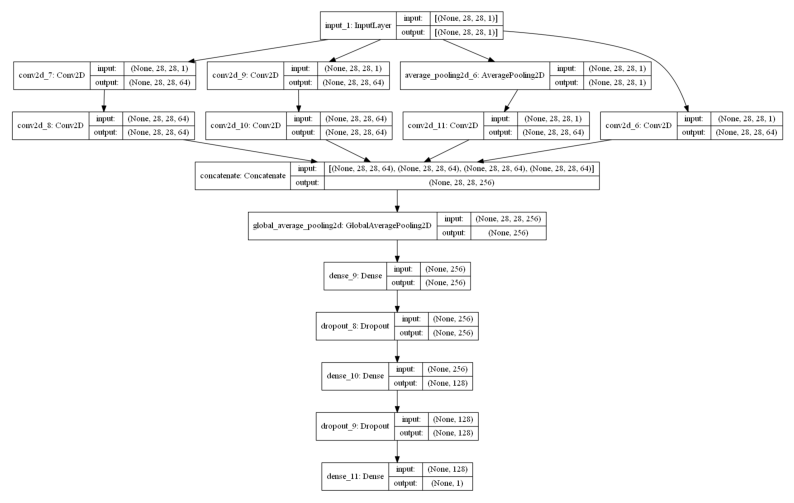

In [31]:
# Visualizzazione della struttura del modello
plot_model(CNN_single_inception, to_file='model_structure_single.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure_single.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Si riporta anche una visualizzazione grafica del modello corrente: l'input viene inviato in parallelo ai quattro branch. Ognuno di essi applica filtri o pooling di dimensioni diverse, e poi i risultaiti vengono concatenati tra di loro. A questo punto, dopo un livello di GlobalAveragePooling, si passa ai layer densi della rete per la classificazione delle immagini.

## CNN con blocchi Inception Consecutivi

Si realizza anche una seconda versione di questa rete, cercando di complicare ulteriormente il modello, per vedere se un numero più alto di parametri aiuta la rete nel trovare nuove relazioni tra i dati, e quindi generalizzare ancora meglio il dataset.
<br>
Per farlo si sceglie di estendere la struttura della CNN precedente andando a inserire in sequenza più blocchi Inception, prima di passare alla parte con layer densi della rete.

In [32]:
def inception_module(x, filters):
    layers = tf.keras.layers
    # Branch 1: Convolution
    branch1 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    
    # Branch 2: Convolution followed by Convolution
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (7, 7), padding='same', activation='relu')(branch2)
    
    # Branch 3: Convolution followed by Convolution
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (11, 11), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by Convolution
    branch4 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output
# Costruzione del modello
def create_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    # Primo blocco Inception
    x = inception_module(inputs, 32)

    # Secondo blocco Inception
    x = inception_module(x, 64)

    # Terzo blocco Inception
    x = inception_module(x, 128)

    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
cnn_inception_extended = create_inception_cnn(input_shape)

# Compilazione del modello
cnn_inception_extended.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
cnn_inception_extended.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 28, 28, 1)    0           input_2[0][0]                    
____________________________________________________________________________________________

Il numero di parametri di questa rete ora è molto più alto rispetto alla sua versione con un solo blocco Inception.

In [33]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history = cnn_inception_extended.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 17s 101ms/step - loss: 0.4811 - accuracy: 0.7729 - val_loss: 0.2785 - val_accuracy: 0.8791
Epoch 2/300
118/118 [==============================] - 9s 73ms/step - loss: 0.3307 - accuracy: 0.8611 - val_loss: 0.2039 - val_accuracy: 0.9130
Epoch 3/300
118/118 [==============================] - 9s 74ms/step - loss: 0.2723 - accuracy: 0.8900 - val_loss: 0.1779 - val_accuracy: 0.9332
Epoch 4/300
118/118 [==============================] - 9s 74ms/step - loss: 0.2381 - accuracy: 0.9052 - val_loss: 0.1844 - val_accuracy: 0.9343
Epoch 5/300
118/118 [==============================] - 9s 74ms/step - loss: 0.1988 - accuracy: 0.9243 - val_loss: 0.1929 - val_accuracy: 0.9332
Epoch 6/300
118/118 [==============================] - 9s 75ms/step - loss: 0.1821 - accuracy: 0.9315 - val_loss: 0.1556 - val_accuracy: 0.9396
Epoch 7/300
118/118 [==============================] - 9s 75ms/step - loss: 0.1597 - accuracy: 0.9397 - val_loss: 0.1141 - val_accurac

Dato l'altissimo numero di parametri di questa rete rispetto a quelle precedenti, il suo training è estramemente più lento. Sulla macchina utilizzata per realizzare questo notebook, infatti, ogni epoca per l'addestramento di questa rete ha impiegato circa 9 secondi, contro gli  1/2 secondi per epoca della rete precedente. 

In [60]:
_ , cnn_inception_extended_accuracy = cnn_inception_extended.evaluate(test_reshaped, test_labels)
print('cnn_inception_extended_accuracy over testing set = ', cnn_inception_extended_accuracy)


y_pred_probs5 = cnn_inception_extended.predict(test_reshaped)
y_pred5 = (y_pred_probs5 > 0.5).astype(int).flatten()
y_true5 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_multi_inception = f1_score(y_true5, y_pred5)
print(f'F1 Score: {f1_cnn_multi_inception}')

# Calcolare la Confusion Matrix
cm_cnn_multi_inception = confusion_matrix(y_true5, y_pred5)

17/17 [==============================] - 1s 20ms/step - loss: 0.0716 - accuracy: 0.9752
cnn_inception_extended_accuracy over testing set =  0.9751908183097839
F1 Score: 0.9833971902937421


L'accuracy di questo modello, tuttavia, non solo non supera quella della versione precedente, ma non supera nemmeno quella del miglior modello basato su LeNet. Sembra dunque evidente che aumentare il numero di parametri non stia più aiutando la rete a ottenere prestazioni migliori. 
<br>
È quindi possibile che questa rete, nonostante l'impiego di Early Stopping e dei livelli di Dropout, vada comunque in overfitting sui dati, generalizzando peggio della sua versione precedente.

In [61]:
add_result_to_csv('CNN Multi Inception', cnn_inception_extended_accuracy)
add_result_to_csv('CNN Multi Inception', f1_cnn_multi_inception, 'f1.csv')

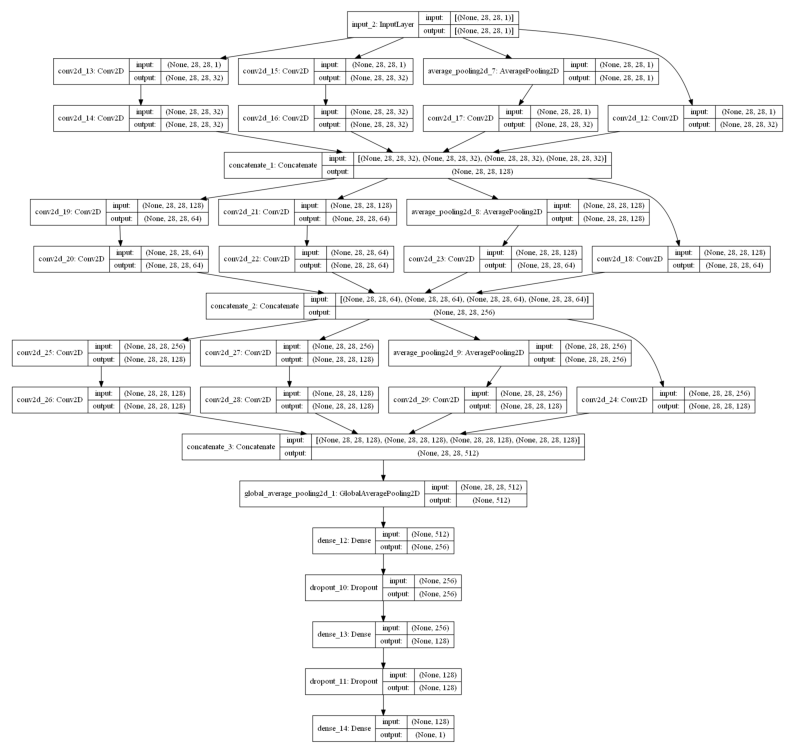

In [36]:
# Visualizzazione della struttura del modello
plot_model(cnn_inception_extended, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Si riporta anche per questa rete la sua struttura grafica, dove è possibile osservare i tre blocchi Inception in sequenza. 

## Data Augmentation sul miglior modello

A questo punto si è scelto di prendere il miglior modello trovato fino ad ora, e osservare il suo comportamento quando utilizzato in combinazione con la tecnica della Data Augmentation.
<br>
L'idea in questo caso è quella di addestrare questo modello con una versione del dataset composta da immagini leggermente modificate rispetto a quelle originali, nella speranza che questo porti la rete a generalizzare meglio i dati, e avere prestazioni migliori sul testing set.

In [37]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Definizione della CNN
input_shape = (28, 28, 1)
CNN_single_inception_da = create_single_inception_cnn(input_shape)

# Compilazione del modello
CNN_single_inception_da.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Configurazione della Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=0,  # rotazione
    width_shift_range=0.05,  # Spostamento casuale orizzontale del 10% della larghezza
    height_shift_range=0.05,  # Spostamento casuale verticale del 10% dell'altezza
    zoom_range=0.05,  # Zoom casuale del 10%
    horizontal_flip=False,  # Ribaltamento casuale orizzontale
    vertical_flip=False  # Senza ribaltamento casuale verticale
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Addestramento del modello con Data Augmentation
historyCNN_single_inception_da = CNN_single_inception_da.fit(
    datagen.flow(x_reshaped_train, x_train_labels, batch_size=32),
    steps_per_epoch=len(x_reshaped_train) // 32,
    epochs=300,
    validation_data=(x_reshaped_valid, x_valid_labels),
    callbacks=[early_stopping]
)

Epoch 1/300
117/117 [==============================] - 3s 16ms/step - loss: 0.5902 - accuracy: 0.7324 - val_loss: 0.5465 - val_accuracy: 0.7487
Epoch 2/300
117/117 [==============================] - 2s 15ms/step - loss: 0.5414 - accuracy: 0.7426 - val_loss: 0.4522 - val_accuracy: 0.7869
Epoch 3/300
117/117 [==============================] - 2s 15ms/step - loss: 0.4385 - accuracy: 0.7961 - val_loss: 0.3112 - val_accuracy: 0.8855
Epoch 4/300
117/117 [==============================] - 2s 15ms/step - loss: 0.3531 - accuracy: 0.8492 - val_loss: 0.2712 - val_accuracy: 0.8887
Epoch 5/300
117/117 [==============================] - 2s 15ms/step - loss: 0.3347 - accuracy: 0.8516 - val_loss: 0.2326 - val_accuracy: 0.9014
Epoch 6/300
117/117 [==============================] - 2s 15ms/step - loss: 0.2735 - accuracy: 0.8862 - val_loss: 0.2050 - val_accuracy: 0.9162
Epoch 7/300
117/117 [==============================] - 2s 15ms/step - loss: 0.2736 - accuracy: 0.8910 - val_loss: 0.2674 - val_accuracy:

In [62]:
# Valutazione del modello sui dati di test
_, CNN_single_inception_da_accuracy = CNN_single_inception_da.evaluate(test_images, test_labels)
print('CNN_single_inception_da over test set = ', CNN_single_inception_da_accuracy)

y_pred_probs6 = CNN_single_inception_da.predict(test_images)
y_pred6 = (y_pred_probs6 > 0.5).astype(int).flatten()
y_true6 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_da = f1_score(y_true6, y_pred6)
print(f'F1 Score: {f1_cnn_da}')

# Calcolare la Confusion Matrix
cm_cnn_da = confusion_matrix(y_true6, y_pred6)

17/17 [==============================] - 0s 21ms/step - loss: 0.0858 - accuracy: 0.9676
CNN_single_inception_da over test set =  0.9675572514533997
F1 Score: 0.9780077619663649


La manipoliazione dei dati di addestramento non sembra essere però una tecnica efficace, riportando una accuracy sul testing set più bassa rispetto allo stesso modello addestrato sul dataset originale.
<br>
Questo è probabilmente dovuto anche alla tipologia delle immagini del dataset, che sono di natura medica. Infatti, osservando anche le immagini visualizzate nelle fasi preliminari di questo notebook, è possibile vedere come il loro livello di zoom e di rotazione sia sempre estremamente simile. Questo è dovuto proprio alla natura scientifica delle immagini, che sono quindi realizzate in maniera rigorosa. 
<br>
Questo aspetto si riflette infatti anche sui milgiori parametri trovati per l'ImageDataGenerator: sono tutti valori che indicano trasformazioni minime delle immagini di input originali. Andando ad alzare questi valori, l'accuracy del modello scede ulteriormente. 
<br>
Probabilmente, su un dataset con immagini meno "standardizzate" questo approccio avrebbe portato a risultati migliori, aiutando la rete a generalizzare meglio. In questo caso invece è possibile che, andando a modificare le immagini per l'addestramento, si sia tolta alla rete la possibilità di imparare dei pattern che poi avrebbe ritrovato anche in fase di validazione/testing.

In [63]:
add_result_to_csv('CNN Single Inception + DA', CNN_single_inception_da_accuracy)
add_result_to_csv('CNN Single Inception + DA', f1_cnn_da, 'f1.csv')

## Analisi Risultati

Nella fase finale di quessto Notebook si vuole andare a confrontare le performance dei vari modelli.

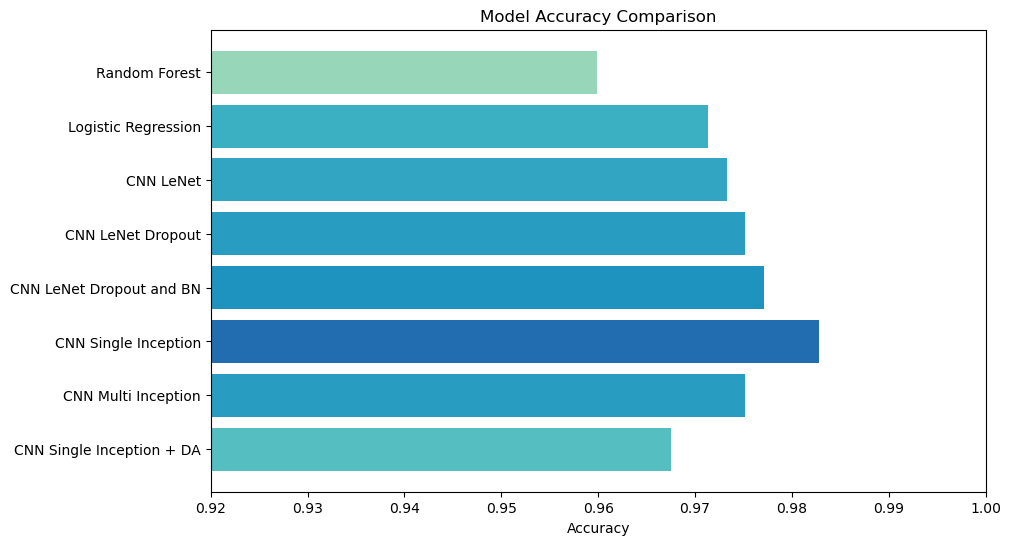

In [64]:
accuracies = []

models = ['Random Forest',
          'Logistic Regression',
          'CNN LeNet',
          'CNN LeNet Dropout',
          'CNN LeNet Dropout and BN',
          'CNN Single Inception',
          'CNN Multi Inception',
          'CNN Single Inception + DA']

for model in models:
    accuracy = read_value_from_csv(model)
    accuracies.append(accuracy)

norm = Normalize(vmin=0.94, vmax=1.0)
colors = plt.cm.YlGnBu(norm(accuracies))# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.92, 1.0)  # Limit the x-axis to better visualize differences
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy at the top
plt.show()

La prima metrica che si prende in considerazione è l'accuracy. 
<br>
Si può notare come Random Forest, che è stato il primo modello realizzato ed utilizzato come baseline, presenti un accuracy sensibilmente inferiore rispetto a tutti gli altri. 
<br>
Il modello che si comporta meglio è sicuramente CNN Single Inception, che è l'unico ad aver fatto registrare un'accuracy superioire al 98%. Ha avuto buone prestazioni rispetto a questa metrica anche la CNN LeNet con Dropout e Batch Normalization, nonostante il numero minore di parametri.  
Da notare anche come il modello con Data Augmentation (DA) abbia prestazioni peggiori di tutte le altre CNN (per i motivi già analizzati) e anche del modello di Regressione Logistica. 
Quest'ultimo, invece, se considerata la sua semplicità rispetto alle CNN, presenta risultati relativamente buoni.
<br>
<br>
*Nota: la scala dell'accuracy è stata limitata all'intervallo* [0.92 - 1] *per esaltare le differenze tra i modelli, che sono così più evidenti.*

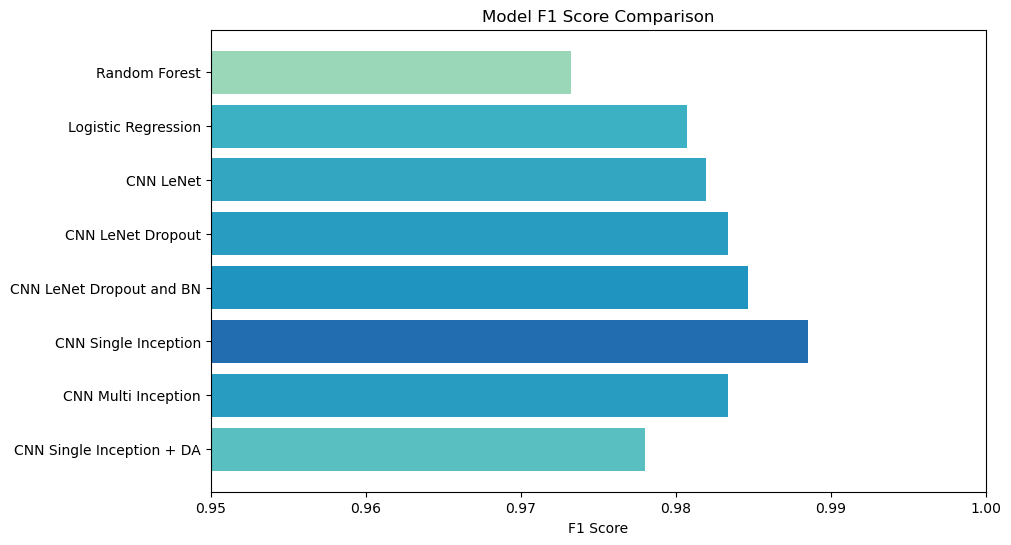

In [65]:
f1s = []
for model in models:
    f1 = read_value_from_csv(model, 'f1.csv')
    f1s.append(f1)

norm = Normalize(vmin=0.96, vmax=1.0)
colors = plt.cm.YlGnBu(norm(f1s))# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, f1s, color=colors)
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0.95, 1.0)  # Limit the x-axis to better visualize differences
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy at the top
plt.show()

Si procede ad analizzare anche i valori dell' F1-score per ogni modello. Si sceglie di utilizzare anche questa metrica per andare a tenere conto sia delle Precision che della Recall dei vari modelli, e del fatto che il dataset non sia perfettamente bilanciato.
<br>
La situazione che emerge da questo grafico è del tutto simile a quella dell'analisi della Accuracy: i modelli migliori si confermano la CNN Single Inception e, a seguire, la CNN LeNet Dropout con BN. Questo ci conferma che entrambi questi modelli presentano valori alti sia per la precision che per la recall.

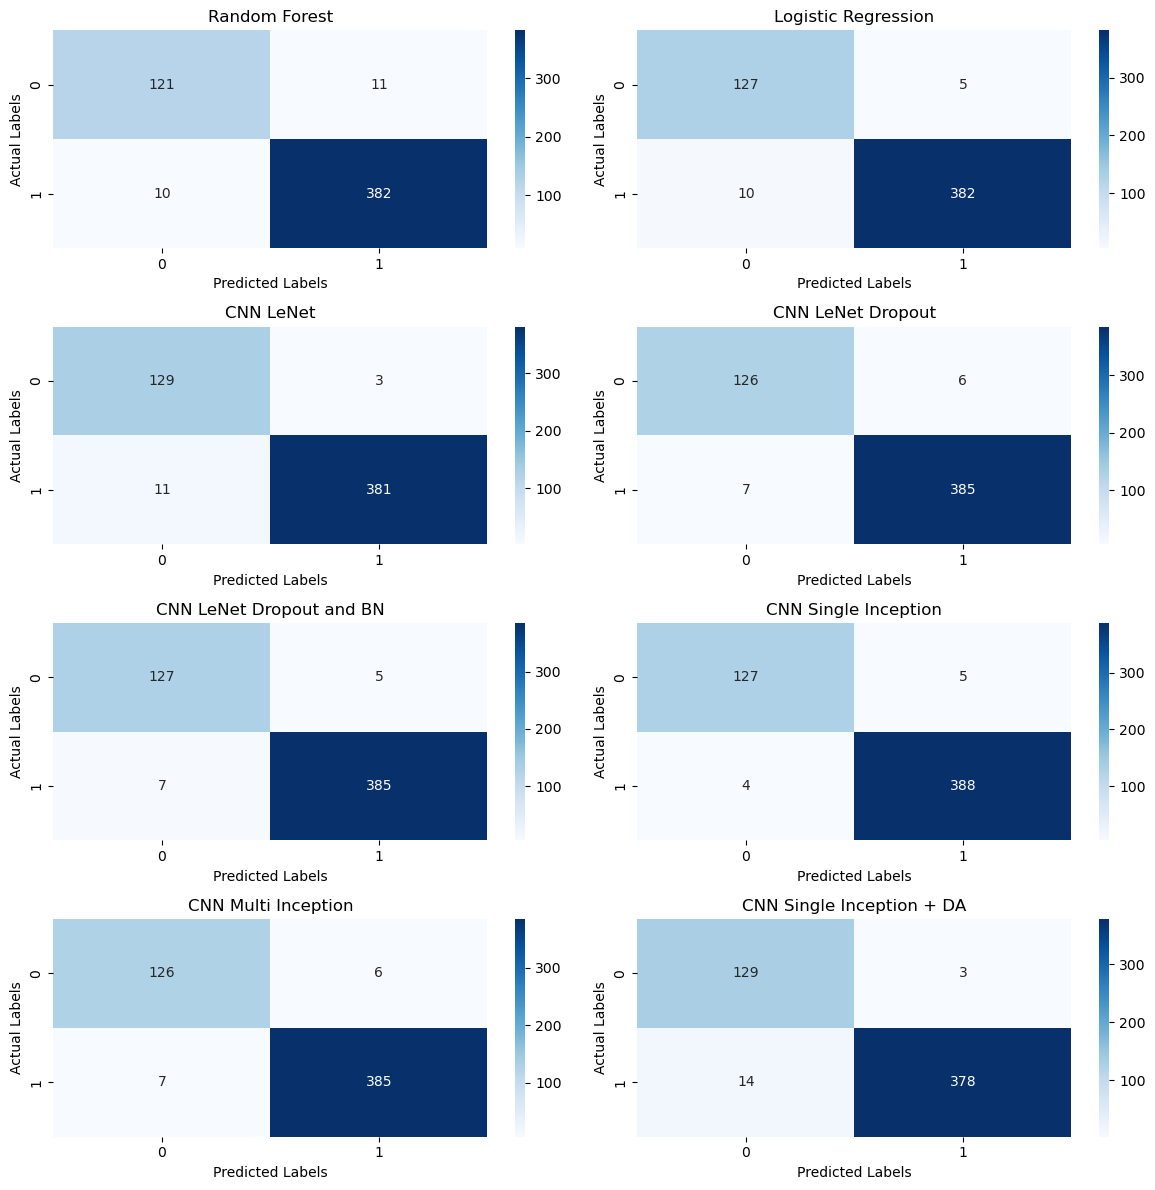

In [66]:

# Lista delle confusion matrix
cm_list = [cm_rf,
           cm_logreg,
           cm_cnn_lenet,
           cm_cnn_lenet_opt,
           cm_cnn_lenet_opt_bn,
           cm_cnn_single_inception,
           cm_cnn_multi_inception,
           cm_cnn_da]

# Numero di confusion matrix
n_cm = len(cm_list)

# Impostare la dimensione della figura e dei subplot
fig, axs = plt.subplots(n_cm // 2, 2, figsize=(12, 12))

# Iterare attraverso la lista di confusion matrix e visualizzarle
for i, (cm, title) in enumerate(zip(cm_list, models)):
    row = i // 2
    col = i % 2
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('Actual Labels')

# Mostrare le confusion matrix
plt.tight_layout()
plt.show()

Infine, si procede all'analisi delle confusion matrix dei modelli. Questo ci consente di avere una visione più dettagliata di come ogni modello si sia comportanto andando a classificare il testing set. In generale i modelli (seppur con qualche eccezione) sembrano soffrire maggiormente di False Negative. 
<br>
Da notare come i modelli migliori (CNN Single Inception e CNN LeNet Dropout + BN) siano quelli che commettono meno errori, ma anche quelli che sembrano essere tra i più "bilanciati" nelle loro predizioni, commettendo un numero di FP e FN molto più vicino rispetto ad altri modelli. Anche Random Forest ha un comportamento simile, con la differenza però che commette decisamente più errori totali. 
<br>
<br>
In conclusione, il **miglior modello è la CNN Single Inception** con:
<br>
Accuracy = 98.28%
<br>
F1-Score = 98.85%
<br>
Precision = 98.72%, Recall = 98.98% {Rispetto alla classe 1}
<br>
Precision = 96.95%, Recall = 96.21% {Rispetto alla classe 0}
<br>
Numero totale errori sul Testing Set = 9